In [1]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import time
import matplotlib.ticker as ticker

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [4]:
def file_parser():
    # Defining variables for file loading
    data_in_path = r'src/Collected Data'
    data_out_path = r'src/Parsed Data'
    line_jsons = [r'2.json',r'3.json',r'4.json',r'5.json',r'6.json',r'7.json',r'8.json',r'9.json',
                  r'12.json',r'13.json',r'14.json',r'15.json',r'16.json',r'17.json',r'18.json',r'19.json',
                  r'20.json',r'21.json',r'22.json',r'23.json',r'24.json',r'25.json',r'26.json',r'27.json']
    point_jsons = [r'29.json',r'30.json',r'31.json',r'32.json',r'33.json',r'34.json',r'35.json',r'36.json']
    
    # Creating/checking output path
    if os.path.isdir(data_out_path) == False:
        os.mkdir(os.path.join(os.getcwd(),data_out_path))
    
    timestamp_list = [filename for filename in os.listdir(data_in_path)]
    
    for timestamp in timestamp_list: 
        # Defining output path
        timestamp_out_path = os.path.join(data_out_path,timestamp)
        
        #print(line_jsons_path, point_jsons_path)
        
        # Creating/checking output paths
        if os.path.isdir(timestamp_out_path) == False:
            # Create directory
            os.mkdir(os.path.join(os.getcwd(),timestamp_out_path))
            
            # Defining file paths
            timestamp_in_path = os.path.join(data_in_path,timestamp)
            point_jsons_path = [os.path.join(timestamp_in_path,x) for x in point_jsons]
            line_jsons_path = [os.path.join(timestamp_in_path,x) for x in line_jsons]
            
            # Reading data
            point_data = pd.concat([gpd.read_file(file) for file in point_jsons_path])
            line_data = pd.concat([gpd.read_file(file) for file in line_jsons_path])
            
            # Writing data
            point_data.to_file(os.path.join(timestamp_out_path,r'points.shp'))
            line_data.to_file(os.path.join(timestamp_out_path,r'lines.shp'))

#file_parser()

In [5]:
def filter_reader():
    data_in_path = r'src/Filters Data'
    #read all shapefiles in filter folder
    filter_list = [os.path.join(data_in_path,filename) for filename in os.listdir(data_in_path) if '.shp' in filename]
    #combine all shapefiles into single geodataframe
    filters = pd.concat([gpd.read_file(file) for file in filter_list]).drop('id',axis=1)
    
    return filters

In [19]:
def pt_compiler(filters):
    data_in_path = r'src/Parsed Data'  
    #input list
    timestamp_list = [filename for filename in os.listdir(data_in_path)]
    #output list
    list_active=[]
    list_inactive=[]
    
    for timestamp in timestamp_list:
        #read timestamp's point shapefile
        point_data = gpd.read_file(os.path.join(data_in_path,timestamp,r'points.shp'))
        point_data = point_data.drop_duplicates(subset='UNITTYPE')
        
        #add timestamp to df
        point_data['timestamp'] = timestamp
        
        #join point data to filters to determine which plows are within maintenance facilities (inactive)
        # and those which are outside mf (active)
        point_data = gpd.sjoin(point_data, filters, how="left", op='within')
        point_data_active = point_data[point_data['Name'].isna()]
        point_data_inactive = point_data[point_data['Name'].isna()==False]
        
        #remove extra columns
        point_data_active.drop(['index_right','Name'],axis=1,inplace=True)
        point_data_inactive.drop(['index_right'],axis=1,inplace=True)
        
        #output to list
        list_active.append(point_data_active)
        list_inactive.append(point_data_inactive)
    
    #join all gdf and output
    active_pt_gdf = pd.concat(list_active)
    inactive_pt_gdf = pd.concat(list_inactive)
    return active_pt_gdf, inactive_pt_gdf

In [7]:
def nbhd_profile_reader(top_num=5,btm_num=5):
    data_in_path = r'src/Open Data'
    #read profiles
    nbhd_profiles = pd.read_csv(os.path.join(data_in_path,r'neighbourhood-profiles-2016-csv.csv'))
    #select income data
    nbhd_profiles = nbhd_profiles[nbhd_profiles['Category']=='Income']
    nbhd_profiles = nbhd_profiles[nbhd_profiles['Characteristic']==r'  Average after-tax income of households in 2015 ($)']
    
    #reformat dataframe to series
    nbhd_profiles = nbhd_profiles.transpose()
    nbhd_profiles = nbhd_profiles.drop(['Category','Characteristic','Data Source','Topic','_id'])
    nbhd_profiles.columns = ['Avg Income']
    
    #change type to float and sort
    nbhd_profiles['Avg Income'] = nbhd_profiles['Avg Income'].str.replace(',', '').astype(float)
    nbhd_profiles = nbhd_profiles.sort_values(by='Avg Income')
    nbhd_profiles['Income Group'] = 'Middle Income'
    nbhd_profiles['Income Group'][-top_num:] = 'Top Avg. Income'
    nbhd_profiles['Income Group'][:btm_num] = 'Bottom Avg. Income'
    
    return nbhd_profiles

In [8]:
def nbhd_reader(nbhd_profiles_df):
    data_in_path = r'src/Open Data'
    
    #read column names for assignment
    nbhd_fields = pd.read_csv(os.path.join(data_in_path,r'Neighbourhoods_fields.csv'))
    column_list = nbhd_fields.to_dict(orient='tight')['data']
    column_dict = { k[0]: k[1] for k in column_list } 
    
    #read and join shapefiles, rename columns
    nbhd_gdf = gpd.read_file(os.path.join(data_in_path,r'Neighbourhoods.shp'))
    nbhd_gdf.rename(columns = column_dict, inplace = True)
    
    #drop unecessary columns
    req_column = ['AREA_ID','AREA_NAME','Shape__Area','Shape__Length','CLASSIFICATION','geometry']
    nbhd_gdf = nbhd_gdf[req_column]
    
    #remove numbers from area name
    nbhd_gdf['AREA_NAME'] = nbhd_gdf.AREA_NAME.str.replace('[ ][(][0-9]+[)]', '', regex=True)
    
    #add income stats to geometry
    nbhd_gdf = nbhd_gdf.join(nbhd_profiles_df,on='AREA_NAME',how='left')
    
    return nbhd_gdf



In [9]:
def nbhd_pt_analysis(active_pt_gdf,nbhd_gdf,weather_df):
    #join point data and neighbourhoods
    nbhd_pt = gpd.sjoin(nbhd_gdf, active_pt_gdf, how="inner", op='contains')
    
    #localize the timestamp
    nbhd_pt_index = pd.DatetimeIndex(pd.to_datetime(nbhd_pt['timestamp'],unit='s'))
    nbhd_pt.set_index(nbhd_pt_index,inplace=True)
    nbhd_pt = nbhd_pt.tz_localize('UTC').tz_convert('EST')
    nbhd_pt.drop('timestamp',axis=1,inplace=True)
    
    #localize timestamp for weather
    weather_df_index = pd.DatetimeIndex(pd.to_datetime(weather_df['timestamp'],unit='s'))
    weather_df.set_index(weather_df_index,inplace=True)
    weather_df = weather_df.tz_localize('UTC').tz_convert('EST')
    weather_df['timestamp'] = weather_df_index
    
    #group by neighbourhood
    nbhd_pt_grouped = nbhd_pt.groupby(['AREA_NAME','Income Group','timestamp']).agg(count=('AREA_NAME','count'))
    
    #plotting
    fig, axs = plt.subplots(nrows=2, figsize=(12, 8),sharex=True)
    fig.suptitle('Average Number of Snowplows by Neighbourhood Income Group', fontsize=18)
    fig.tight_layout()
    sns.lineplot(data=weather_df,x='timestamp',y='Precip. Amount (mm)',color='grey',alpha=0.2,ax=axs[0])
    l1 = axs[0].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    axs[0].fill_between(x1,y1,color='grey', alpha=0.3)
    sns.lineplot(data=nbhd_pt_grouped,x='timestamp', y='count',hue='Income Group',ax=axs[1])
    axs[1].set_ylabel('Avg. No. of Snowplows per Nbhd.', fontsize=14)
    
    return nbhd_pt_grouped

In [10]:
def district_reader():
    data_in_path = r'src/Open Data'
    
    #read and join shapefiles, rename columns
    district_gdf = gpd.read_file(os.path.join(data_in_path,r'COMMUNITY_COUNCIL_WGS84.shp'))
    
    #drop unecessary columns
    req_column = ['AREA_NAME','geometry']
    district_gdf = district_gdf[req_column]
    
    #remove numbers from area name
    district_gdf['AREA_NAME'] = district_gdf.AREA_NAME.str.replace(' COMMUNITY COUNCIL', '', regex=True)
    
    return district_gdf

In [22]:
def district_pt_analysis(district_pt_gdf,district_gdf,weather_df):
    #join point data and neighbourhoods
    district_pt = gpd.sjoin(district_gdf, district_pt_gdf, how="inner", op='contains')
    
    #localize the timestamp
    district_pt_gdf_index = pd.DatetimeIndex(pd.to_datetime(district_pt['timestamp'],unit='s'))
    district_pt.set_index(district_pt_gdf_index,inplace=True)
    district_pt = district_pt.tz_localize('UTC').tz_convert('EST')
    district_pt.drop('timestamp',axis=1,inplace=True)
    
    #localize timestamp for weather
    weather_df_index = pd.DatetimeIndex(pd.to_datetime(weather_df['timestamp'],unit='s'))
    weather_df.set_index(weather_df_index,inplace=True)
    weather_df = weather_df.tz_localize('UTC').tz_convert('EST')
    weather_df['timestamp'] = weather_df_index
    
    #group by district
    district_pt_grouped = district_pt.groupby(['AREA_NAME','timestamp']).agg(count=('AREA_NAME','count'))
    
    #plotting
    fig, axs = plt.subplots(nrows=2, figsize=(12, 8),sharex=True)
    fig.suptitle('Total Number of Snowplows by District', fontsize=18)
    fig.tight_layout()
    sns.lineplot(data=weather_df,x='timestamp',y='Precip. Amount (mm)',color='grey',alpha=0.2,ax=axs[0])
    l1 = axs[0].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    axs[0].fill_between(x1,y1,color='grey', alpha=0.3)
    sns.lineplot(data=district_pt_grouped,x='timestamp', y='count',hue='AREA_NAME',ax=axs[1])
    axs[1].set_ylabel('Number of Snowplows', fontsize=14)
    plt.legend(title = "District Name")
    
    return district_pt_grouped

In [28]:
def mf_pt_analysis(mf_pt_gdf,mf_filter,weather_df):
    #localize the timestamp
    mf_pt_gdf_index = pd.DatetimeIndex(pd.to_datetime(mf_pt_gdf['timestamp'],unit='s'))
    mf_pt_gdf.set_index(mf_pt_gdf_index,inplace=True)
    mf_pt_gdf = mf_pt_gdf.tz_localize('UTC').tz_convert('EST')
    mf_pt_gdf.drop('timestamp',axis=1,inplace=True)
    
    #localize timestamp for weather
    weather_df_index = pd.DatetimeIndex(pd.to_datetime(weather_df['timestamp'],unit='s'))
    weather_df.set_index(weather_df_index,inplace=True)
    weather_df = weather_df.tz_localize('UTC').tz_convert('EST')
    weather_df['timestamp'] = weather_df_index
    
    #group point data by mf name
    mf_pt_grouped = mf_pt_gdf.groupby(['Name','timestamp']).agg(count=('Name','count'))
    
    #filter desired mf (if any given)
    mf_pt_grouped = mf_pt_grouped[mf_pt_grouped.index.get_level_values('Name').isin(mf_filter)]
    
    #find min and max
    mf_utility_group = mf_pt_gdf.groupby(['timestamp']).agg(count=('Name','count'))
    mf_util_min = mf_utility_group.max()
    mf_util_max = mf_utility_group.min()
    num_plow = 800 #hard coded based on shapefile downloaded
    
    util_min = 1-mf_util_min/num_plow
    util_max = 1-mf_util_max/num_plow
    print('Minimum plow utilization: '+str(round(util_min*100))+"%")
    print('Maximum plow utilization: '+str(round(util_max*100))+"%")
    
    #plotting
    fig, axs = plt.subplots(nrows=2, figsize=(12, 8),sharex=True)
    fig.suptitle('Number of Inactive Snowplows by Maintenance Facility', fontsize=18)
    fig.tight_layout()
    sns.lineplot(data=weather_df,x='timestamp',y='Precip. Amount (mm)',color='grey',alpha=0.2,ax=axs[0])
    l1 = axs[0].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    axs[0].fill_between(x1,y1,color='grey', alpha=0.3)
    sns.lineplot(data=mf_pt_grouped,x='timestamp', y='count',hue='Name',ax=axs[1], legend='brief')
    axs[1].set_ylabel('Number of Inactive Snowplows', fontsize=14)
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,ncol=1)
    
    return mf_pt_grouped

In [13]:
def velocity_pt_analysis(active_pt_gdf):
    #localize the timestamp
    active_pt_gdf_index = pd.DatetimeIndex(pd.to_datetime(active_pt_gdf['timestamp'],unit='s'))
    active_pt_gdf.set_index(active_pt_gdf_index,inplace=True)
    active_pt_gdf = active_pt_gdf.tz_localize('UTC').tz_convert('EST')
    active_pt_gdf.drop('timestamp',axis=1,inplace=True)
    
    #join point data and neighbourhoods
    active_pt_gdf['VELOCITY'] = active_pt_gdf['VELOCITY'].astype(float)
    velocity_pt_filtered = active_pt_gdf[active_pt_gdf['VELOCITY']>0]
    velocity_pt_grouped = velocity_pt_filtered.groupby(['timestamp']).agg(vel=('VELOCITY','mean'))

    #plotting
    plt.figure(figsize=(15, 10))
    plt.title('Average Velocity of Moving Snowplows', fontsize=18)
    ax = sns.lineplot(data=velocity_pt_grouped,x='timestamp', y='vel')
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel('Timestamp', fontsize=14)
    ax.set_ylabel('Average Velocity', fontsize=14)
    plt.legend(loc = 2, bbox_to_anchor = (1,1))
    
    plt.show()
    
    return velocity_pt_grouped

In [14]:
def weather_reader():
    data_in_path = r'src/Weather Data'
    
    #read and join shapefiles, rename columns
    weather_df = pd.read_csv(os.path.join(data_in_path,r'YTZ_weather.csv'))
    weather_df['timestamp'] = pd.DatetimeIndex(pd.to_datetime(weather_df['Date/Time (LST)']),tz='EST').tz_convert(tz='UTC').astype(np.int64)/10**9
    
    #set time index
    weather_index = pd.DatetimeIndex(weather_df["Date/Time (LST)"],tz='EST')
    weather_df.set_index(weather_index,inplace=True)
    
    #drop unecessary columns
    req_column = ['timestamp','Precip. Amount (mm)']
    weather_df = weather_df[req_column]
    
    #drop empty data
    weather_df.dropna(inplace=True)
    weather_df = weather_df.drop_duplicates()
    
    return weather_df

,timestamp,Precip. Amount (mm)
Date/Time (LST),,
2022-01-01 00:00:00-05:00,1.641013e+09,0.0
2022-01-01 01:00:00-05:00,1.641017e+09,0.0
2022-01-01 02:00:00-05:00,1.641020e+09,0.0
2022-01-01 03:00:00-05:00,1.641024e+09,0.0
2022-01-01 04:00:00-05:00,1.641028e+09,0.0
...,...,...
2022-04-04 19:00:00-05:00,1.649117e+09,0.0
2022-04-04 20:00:00-05:00,1.649120e+09,0.0
2022-04-04 21:00:00-05:00,1.649124e+09,0.0


                           count
timestamp                       
2022-02-17 11:17:23-05:00    782
2022-02-17 11:23:41-05:00    783
2022-02-17 11:29:52-05:00    783
2022-02-17 11:36:00-05:00    784
2022-02-17 11:42:08-05:00    784
...                          ...
2022-02-19 08:50:57-05:00    636
2022-02-19 08:57:10-05:00    637
2022-02-19 09:03:23-05:00    636
2022-02-19 09:09:41-05:00    644
2022-02-19 09:15:55-05:00    645

[441 rows x 1 columns]
count    787
dtype: int64
count    267
dtype: int64
Minimum plow utilization: count    2.0
dtype: float64%
Maximum plow utilization: count    67.0
dtype: float64%


No handles with labels found to put in legend.


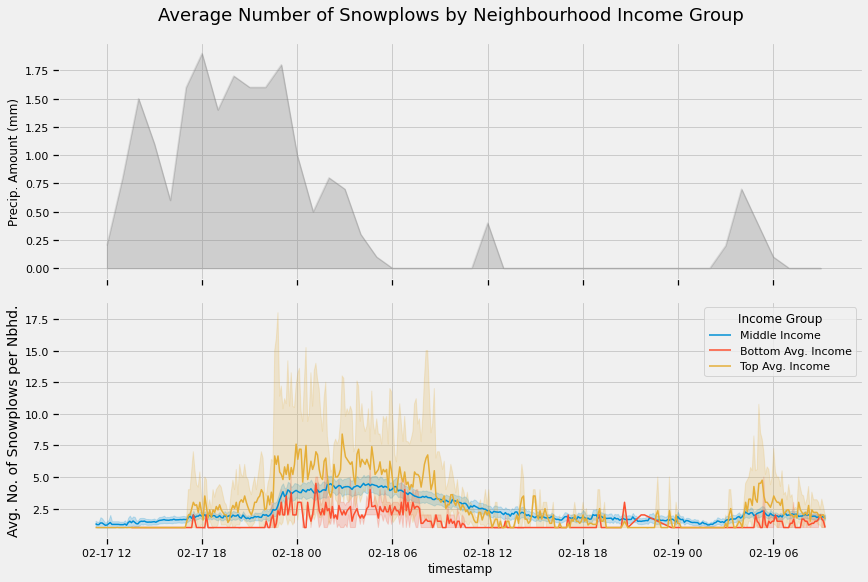

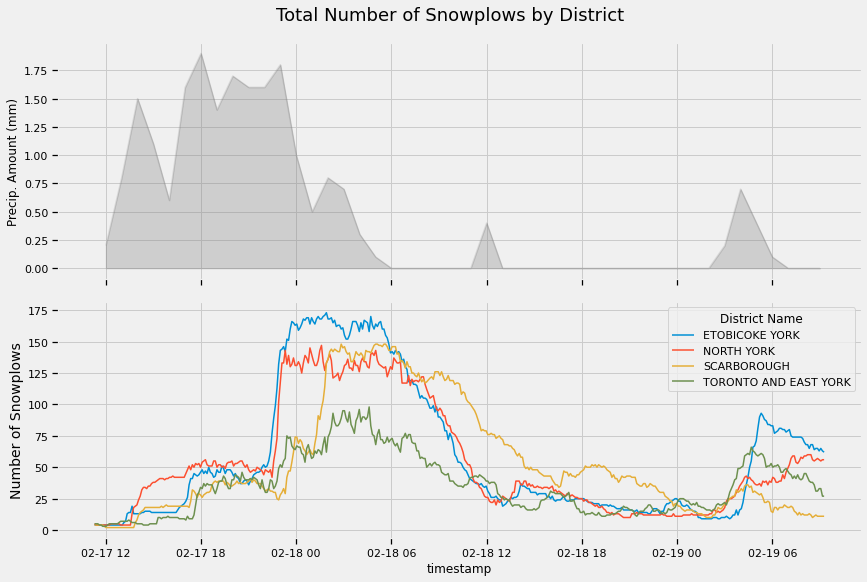

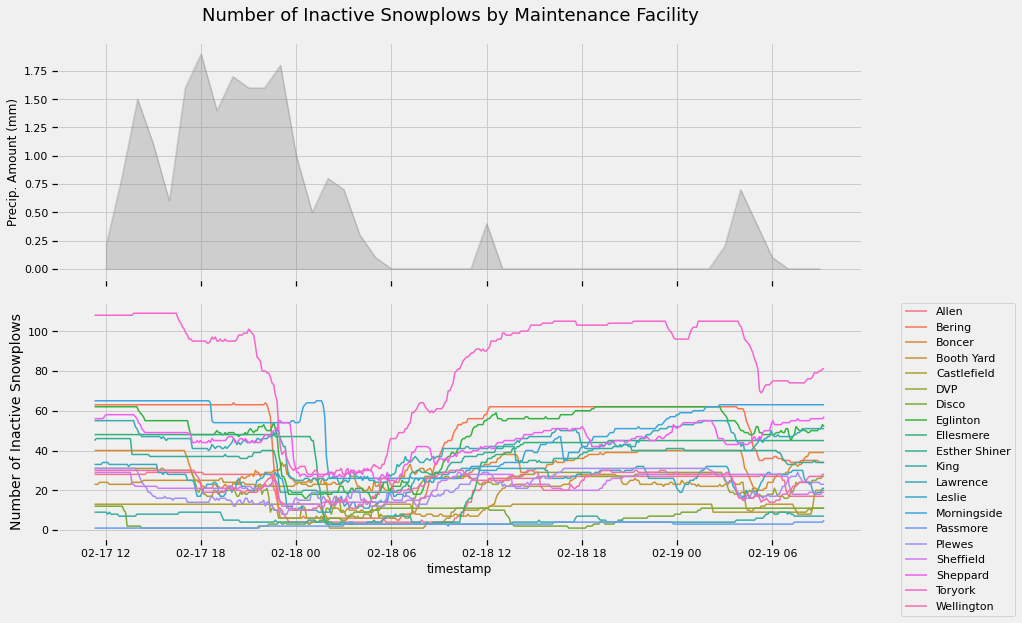

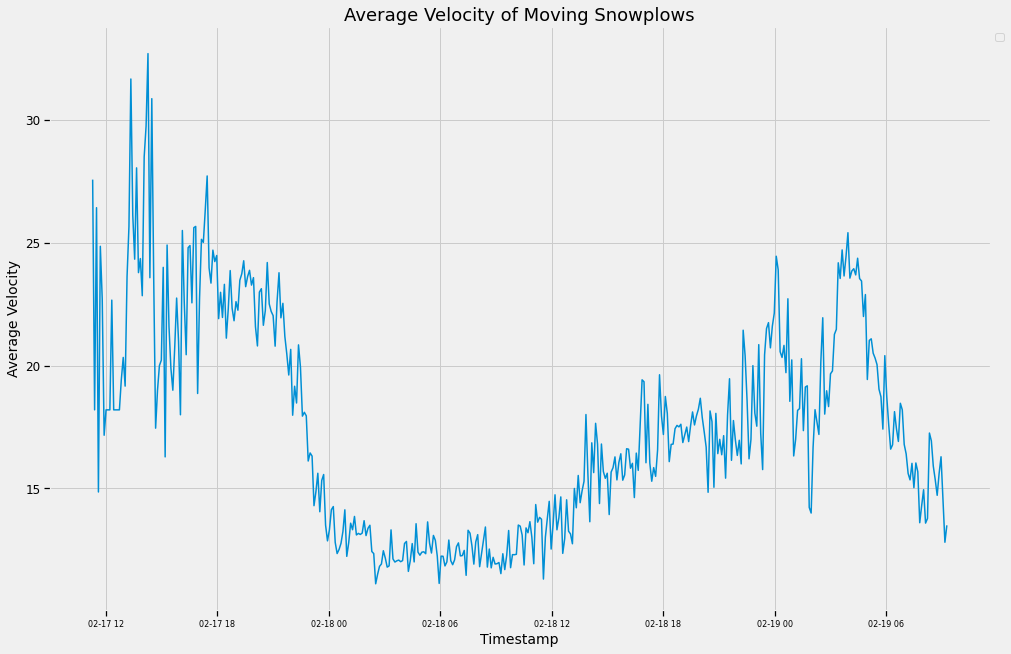

In [29]:
# Run the file parser before the main script if the files have not yet been converted to shapefile
#file_parser()

def main():
    ## storm events:
    #hard coding individual storm periods
    storm1 = [1643815160,1643998995]
    storm2 = [1645114643,1645280155]
    storms = [storm1,storm2]
    
    ## plows:
    #read filters for maintenance facilities
    filters = filter_reader()
    #compile points into dataframes
    active_pt_gdf, inactive_pt_gdf = pt_compiler(filters)
    ## maintenance facilities:
    # compile mf names
    mf_filter = inactive_pt_gdf['Name'].tolist()
    
    ## neighbourhoods:
    #number of top and bottom to assess
    top_num = 5
    btm_num = 5
    #compile neighbourhood profiles, top and bottom
    nbhd_profiles_df = nbhd_profile_reader(top_num,btm_num)
    
    # read neighbourhoods and append profiles
    nbhd_gdf = nbhd_reader(nbhd_profiles_df)
    
    ## districts:
    district_gdf = district_reader()
    
    ## weather:
    weather_df = weather_reader()
    
    ## data by storm:
    for storm in storms:
        #select data based on storm event timestamps
        active_pt_gdf_storm = active_pt_gdf[active_pt_gdf['timestamp'].astype(int).between(storm[0],storm[1])]
        inactive_pt_gdf_storm = inactive_pt_gdf[inactive_pt_gdf['timestamp'].astype(int).between(storm[0],storm[1])]
        
        weather_df_storm = weather_df[weather_df['timestamp'].astype(int).between(storm[0],storm[1])]
        ## plotting:
        # plot top and bottom neighbourhoods by point count
        nbhd_pt_analysis(active_pt_gdf_storm,nbhd_gdf,weather_df_storm)
        #plot districts
        district_pt_analysis(active_pt_gdf_storm,district_gdf,weather_df_storm)
        # plot mf by point count
        mf_pt_analysis(inactive_pt_gdf_storm,mf_filter,weather_df_storm)
        #plot average velocity
        velocity_pt_analysis(active_pt_gdf_storm)
    

main()